<a href="https://colab.research.google.com/github/DanielaVL/PrediccionRendimientoAcademico/blob/main/ModelosML_CursoMatematicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
#Se importan las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
from yellowbrick.regressor import residuals_plot

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import learning_curve

from sklearn.ensemble import AdaBoostRegressor

# **Carga de dataset**

In [103]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip

--2023-11-06 18:05:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘student.zip.4’

student.zip.4           [ <=>                ]  20.00K  --.-KB/s    in 0.05s   

2023-11-06 18:05:09 (416 KB/s) - ‘student.zip.4’ saved [20478]



In [104]:
!unzip student.zip

Archive:  student.zip
replace student-mat.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-mat.csv         
replace student-por.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-por.csv         
replace student-merge.R? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-merge.R         
replace student.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student.txt             


In [105]:
#Datos del curso
data = pd.read_csv("student-mat.csv", sep=";")
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [106]:
# Resumen estadístico de las columnas numéricas
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [107]:
# Resumen de las estadísticas descriptivas de las columnas categóricas
data.describe(include=['object'])

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,307,281,354,141,217,145,273,344,242,214,201,314,375,329,263


In [108]:
# Información sobre la estructura del DataFrame (tipos de datos, cantidad de valores no nulos)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [109]:
# Creación del DataFrame
df = pd.DataFrame(data)

In [110]:
# Separación de datos categóricos y numéricos
datos_categoricos = df.select_dtypes(include=['object'])
datos_numericos = df.select_dtypes(exclude=['object'])

In [111]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
    school sex address famsize Pstatus      Mjob      Fjob  reason guardian  \
0       GP   F       U     GT3       A   at_home   teacher  course   mother   
1       GP   F       U     GT3       T   at_home     other  course   father   
2       GP   F       U     LE3       T   at_home     other   other   mother   
3       GP   F       U     GT3       T    health  services    home   mother   
4       GP   F       U     GT3       T     other     other    home   father   
..     ...  ..     ...     ...     ...       ...       ...     ...      ...   
390     MS   M       U     LE3       A  services  services  course    other   
391     MS   M       U     LE3       T  services  services  course   mother   
392     MS   M       R     GT3       T     other     other  course    other   
393     MS   M       R     LE3       T  services     other  course   mother   
394     MS   M       U     LE3       T     other   at_home  course   father   

    schoolsup famsup paid activi

In [112]:
# Codificación one-hot a las columnas categóricas del DataFrame
datos_categoricos = pd.get_dummies(datos_categoricos, columns=['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])

In [113]:
print("Datos Categóricos:")
print(datos_categoricos)

print("\nDatos Numéricos:")
print(datos_numericos)

Datos Categóricos:
     school_GP  school_MS  sex_F  sex_M  address_R  address_U  famsize_GT3  \
0            1          0      1      0          0          1            1   
1            1          0      1      0          0          1            1   
2            1          0      1      0          0          1            0   
3            1          0      1      0          0          1            1   
4            1          0      1      0          0          1            1   
..         ...        ...    ...    ...        ...        ...          ...   
390          0          1      0      1          0          1            0   
391          0          1      0      1          0          1            0   
392          0          1      0      1          1          0            1   
393          0          1      0      1          1          0            0   
394          0          1      0      1          0          1            0   

     famsize_LE3  Pstatus_A  Pstatus_T  ... 

In [114]:
#  Creación de un nuevo DataFrame que contiene tanto las columnas numéricas originales como las columnas one-hot codificadas
df_ohe = pd.concat([datos_numericos, datos_categoricos], axis = 1)
df_ohe.shape

(395, 59)

In [115]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 59 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                395 non-null    int64
 1   Medu               395 non-null    int64
 2   Fedu               395 non-null    int64
 3   traveltime         395 non-null    int64
 4   studytime          395 non-null    int64
 5   failures           395 non-null    int64
 6   famrel             395 non-null    int64
 7   freetime           395 non-null    int64
 8   goout              395 non-null    int64
 9   Dalc               395 non-null    int64
 10  Walc               395 non-null    int64
 11  health             395 non-null    int64
 12  absences           395 non-null    int64
 13  G1                 395 non-null    int64
 14  G2                 395 non-null    int64
 15  G3                 395 non-null    int64
 16  school_GP          395 non-null    uint8
 17  school_MS       

# **Análisis de variables y exploración de datos**

In [116]:
# Se crea un arreglo de nombres de columnas a partir del DataFrame
columns = df_ohe.columns.to_numpy()

In [117]:
len(columns)

59

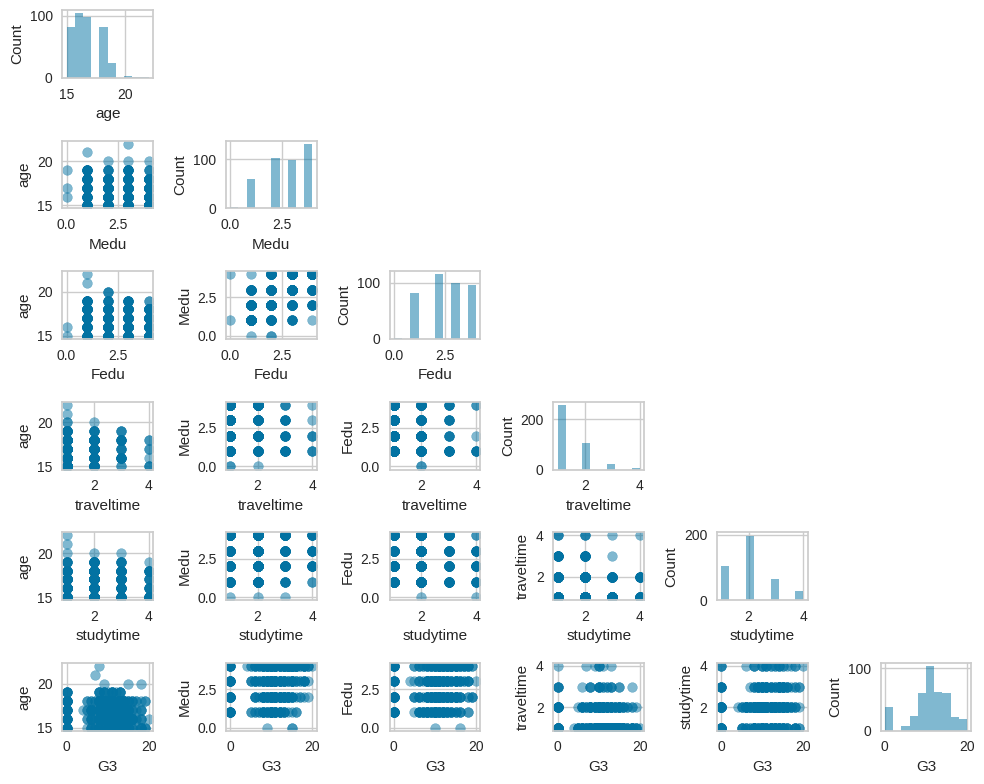

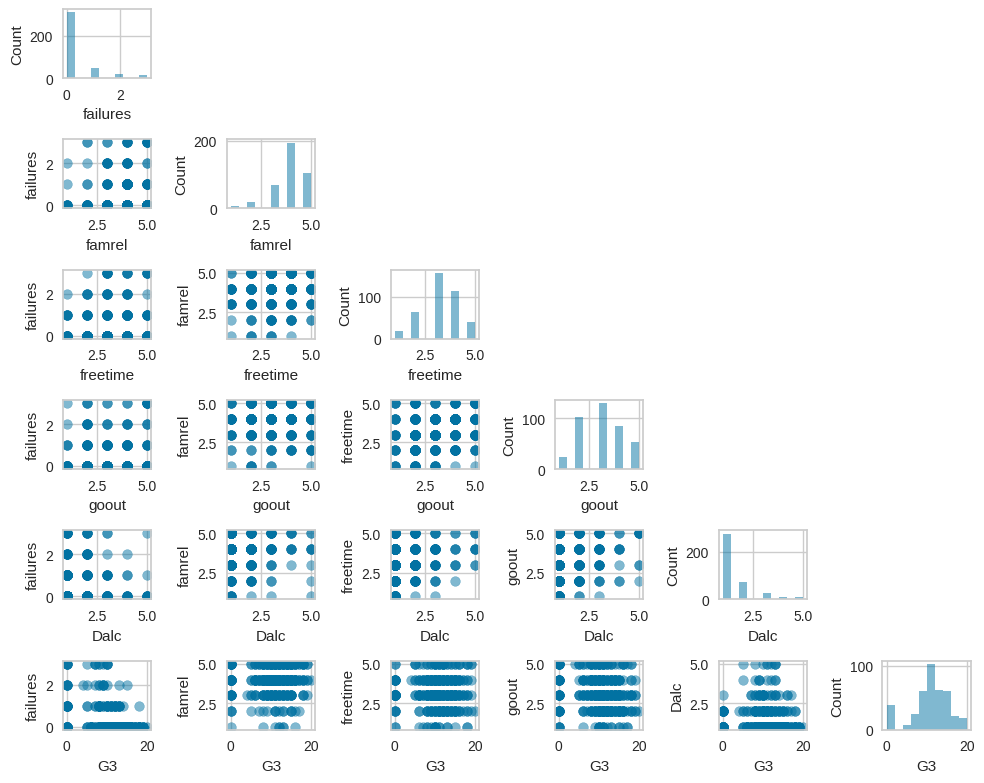

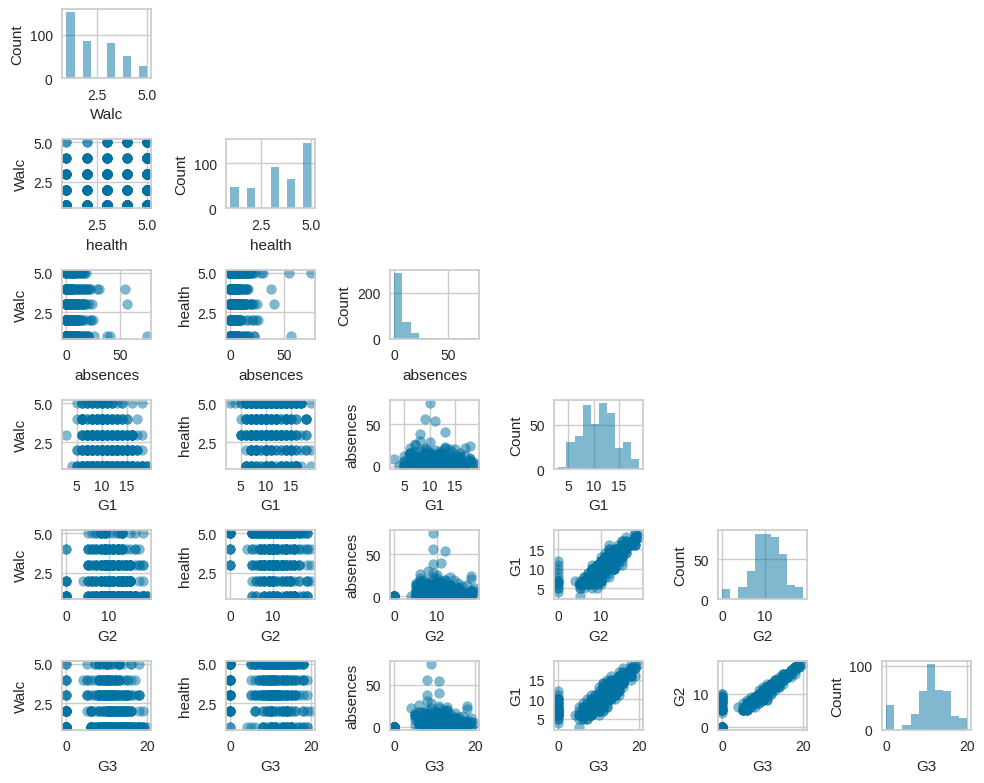

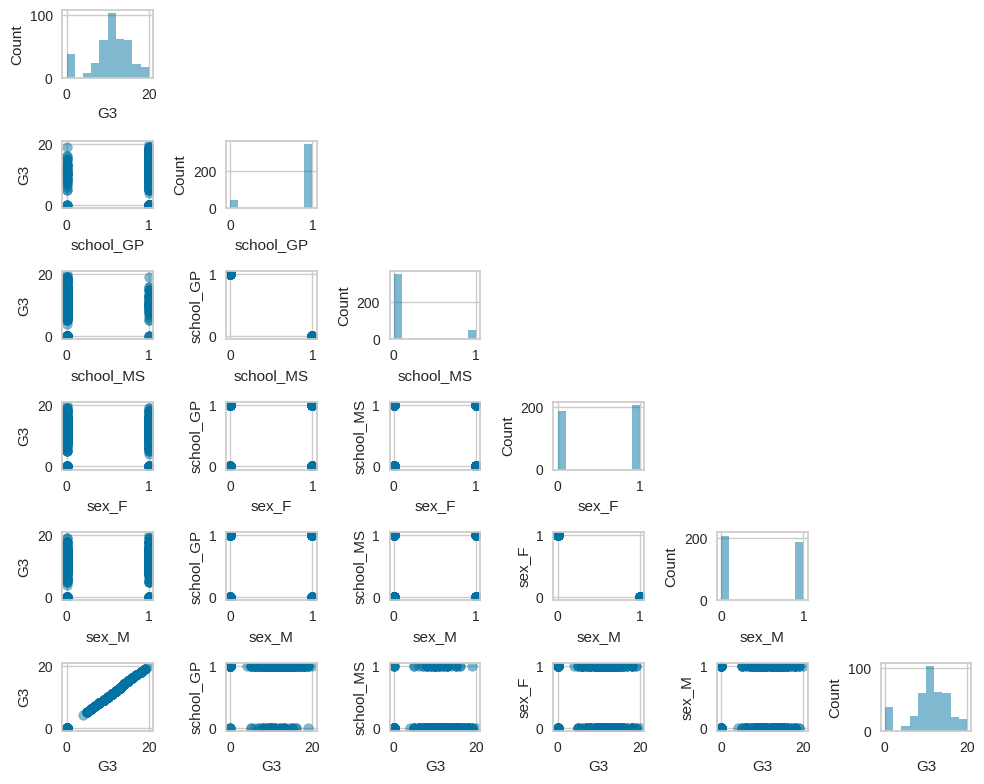

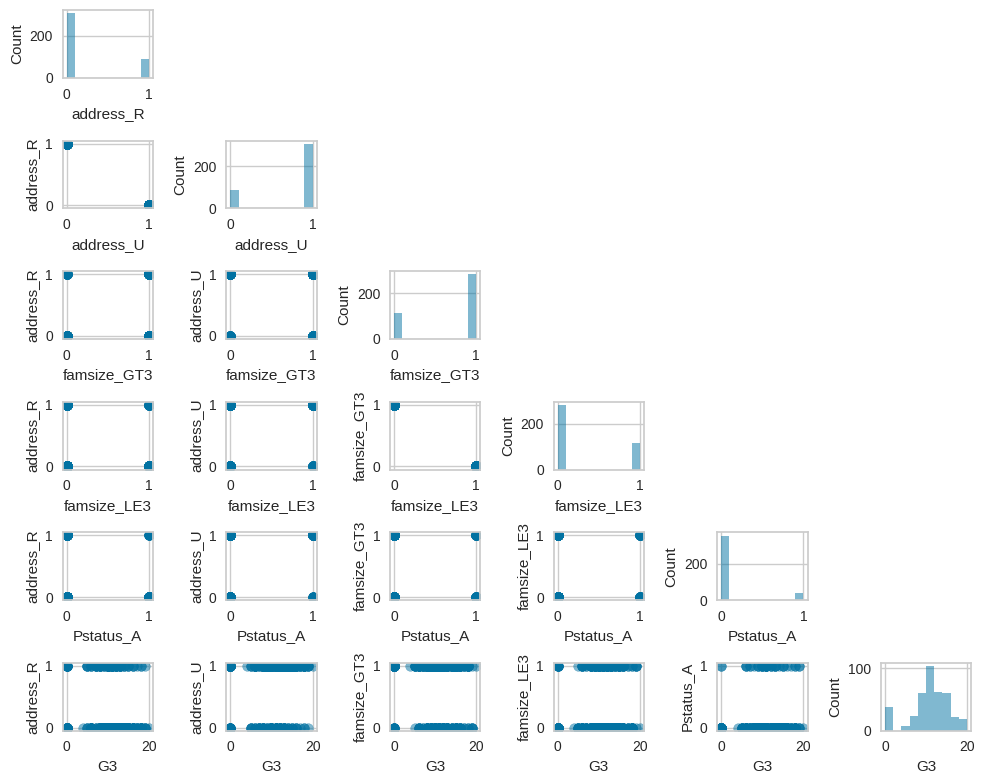

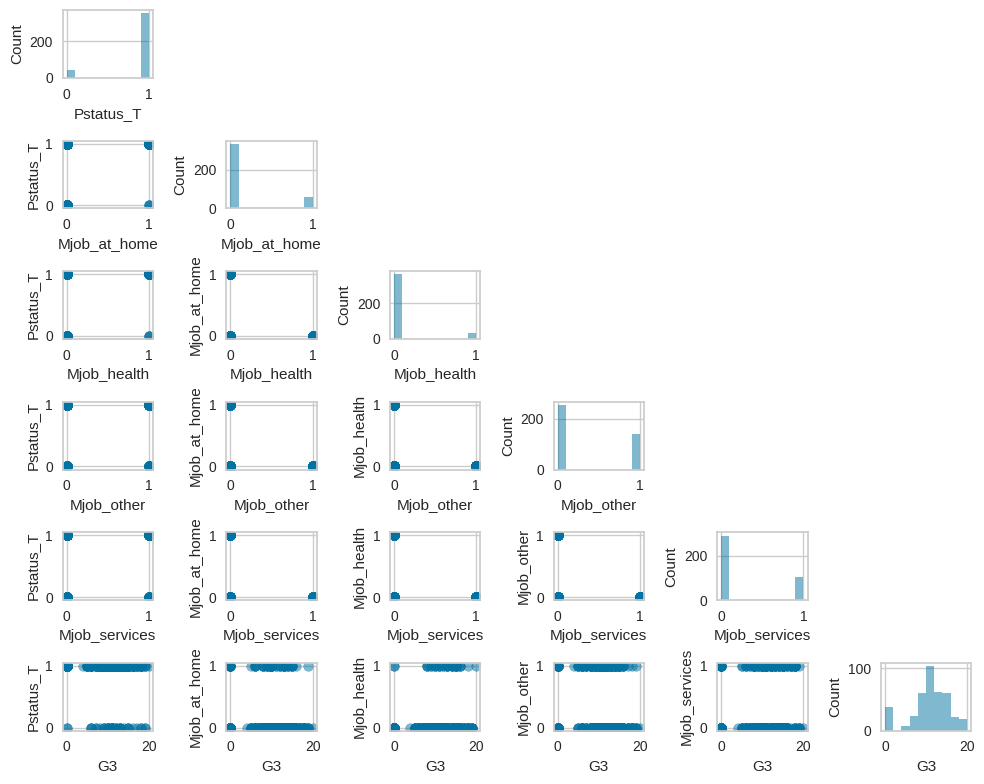

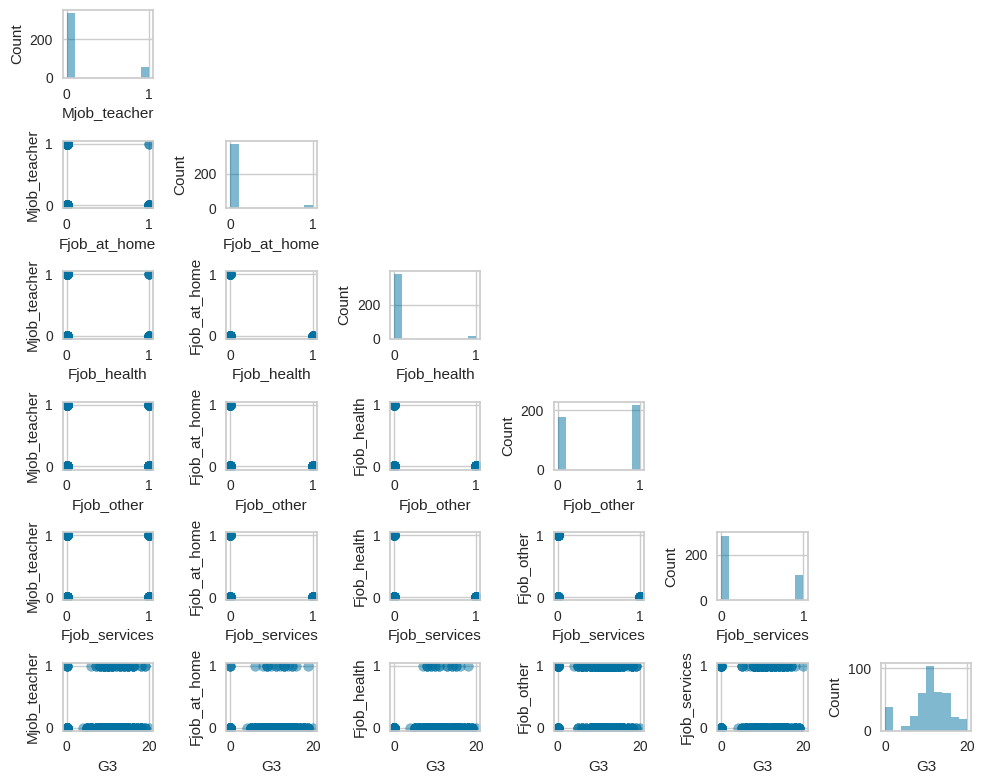

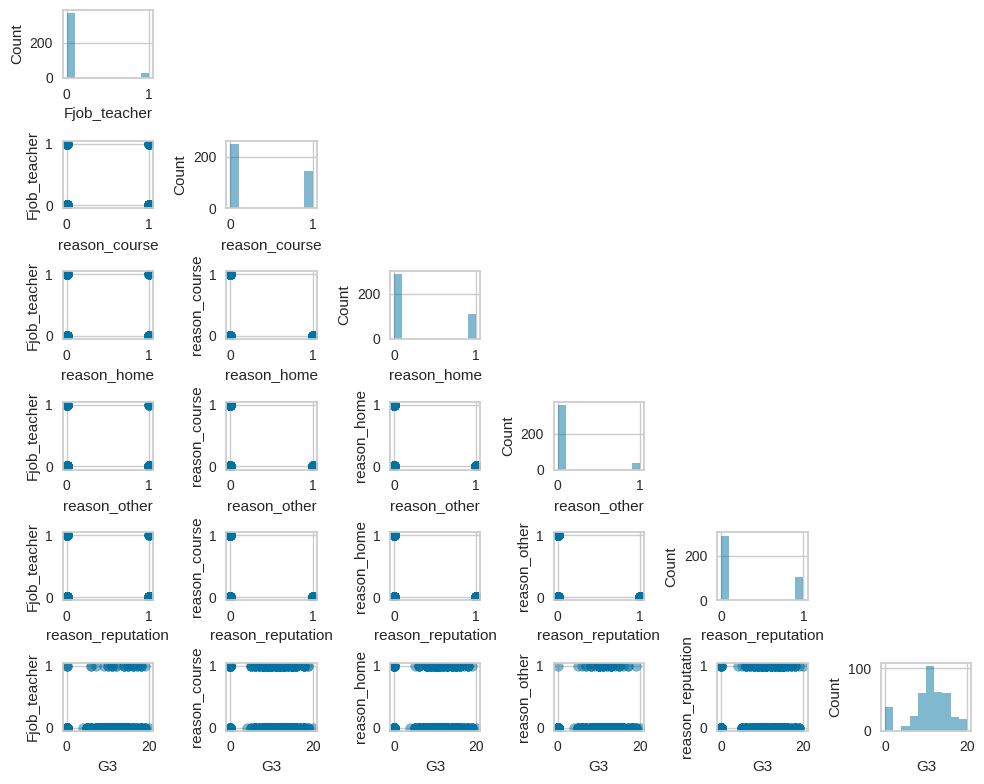

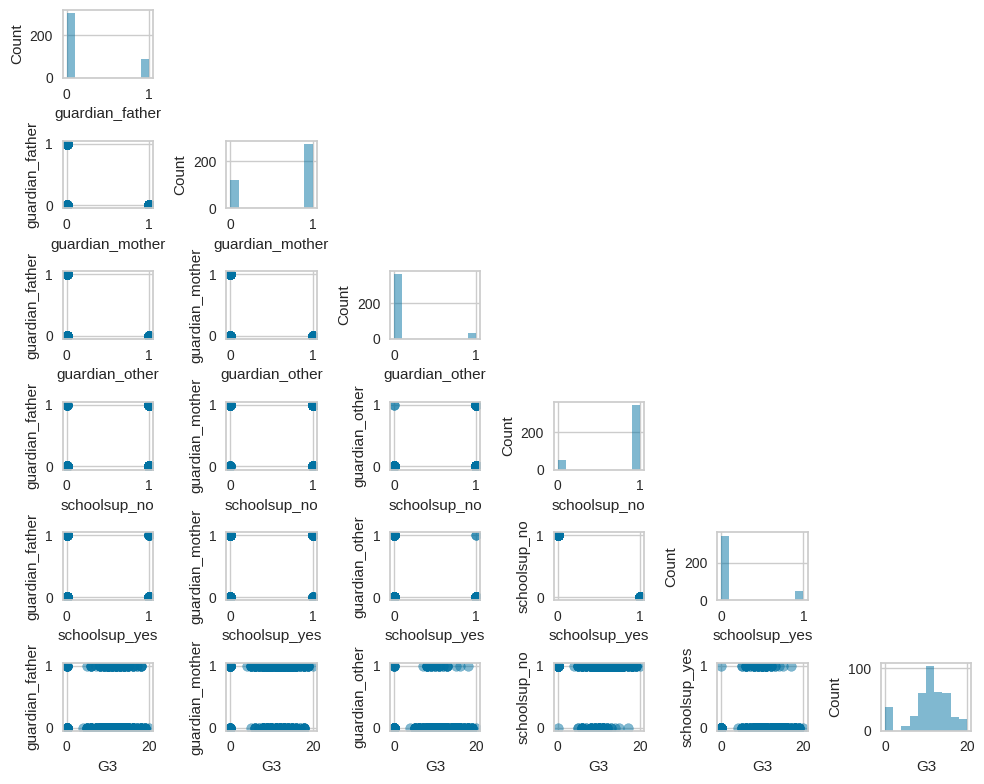

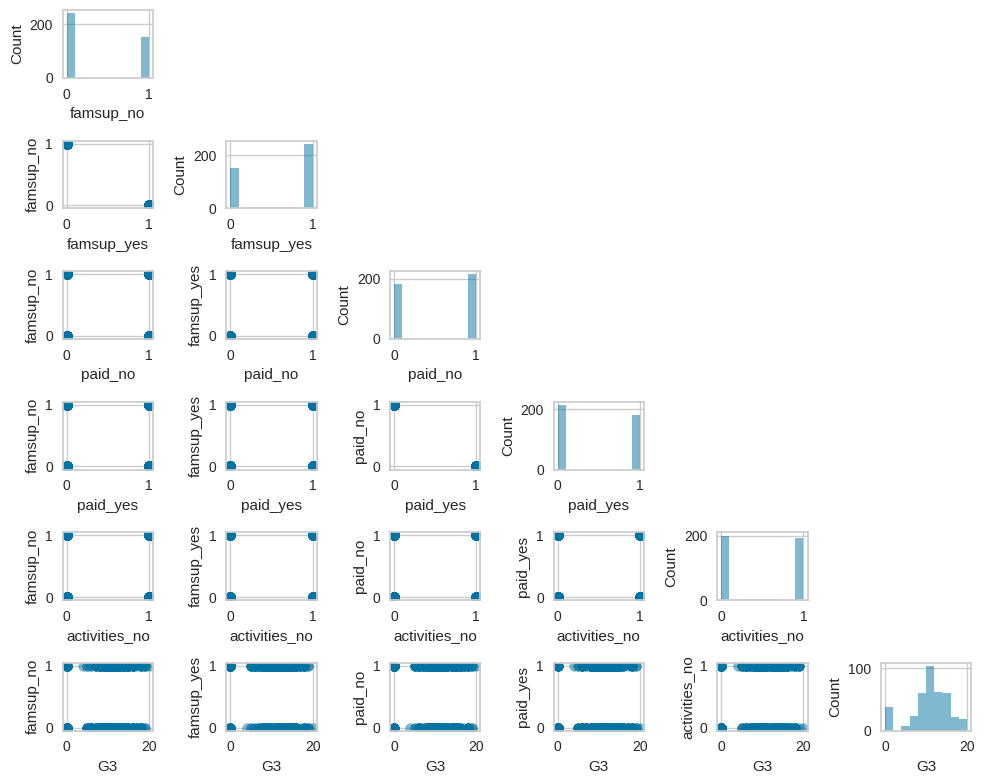

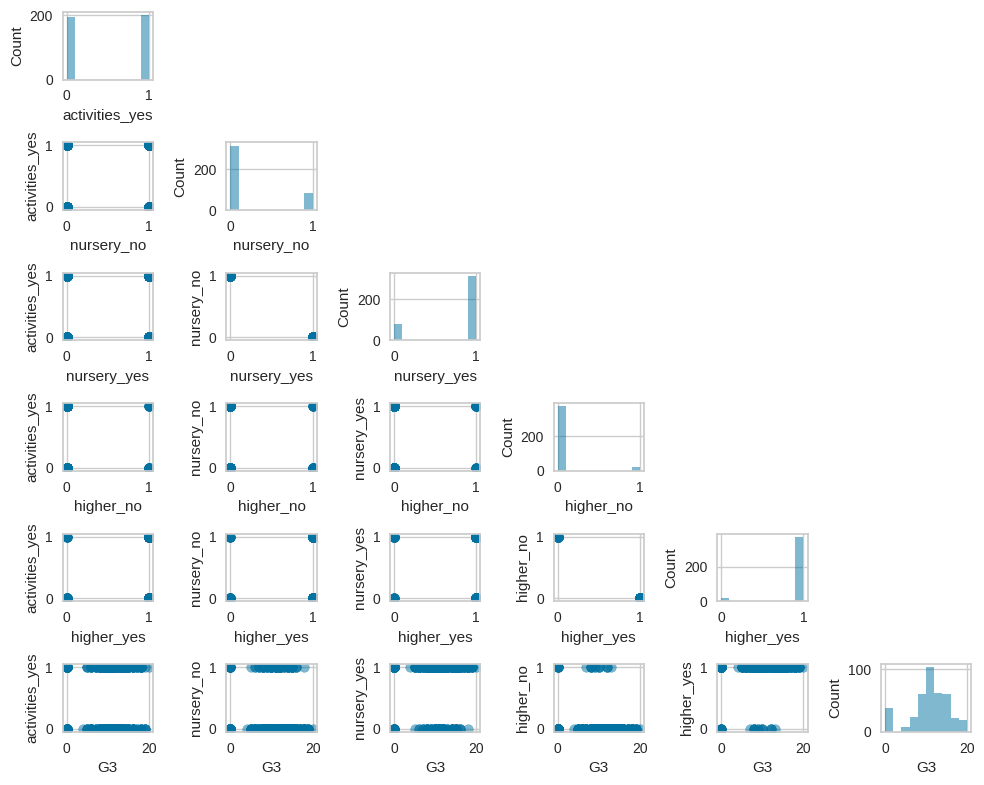

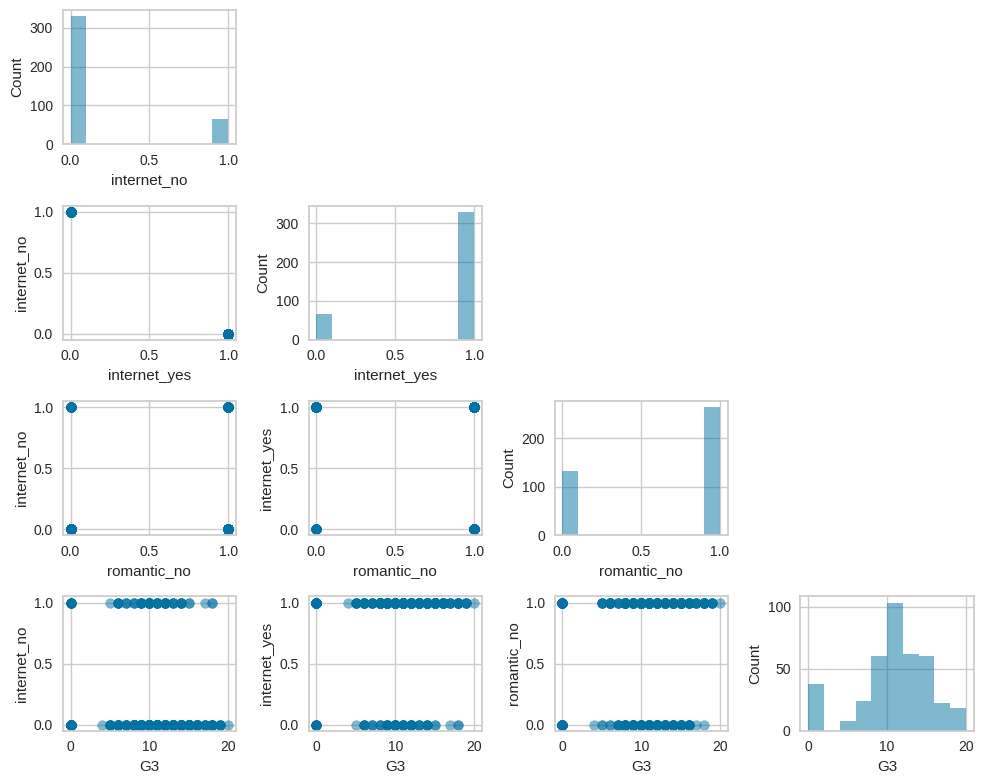

In [118]:
# Se explora la relación entre un conjunto específico de variables con la variable objetivo 'G3' por medio de gráficos de dispersión
for i in range(12):
  if i == 11:
    aux = columns[5*i:-1]
  else:
    aux = columns[5*i:5*(i+1)]
  aux = np.append(aux, 'G3')
  scatterplotmatrix(df_ohe[aux].values, figsize=(10, 8), names=df_ohe[aux].columns, alpha=0.5)
  plt.tight_layout()
  plt.show()

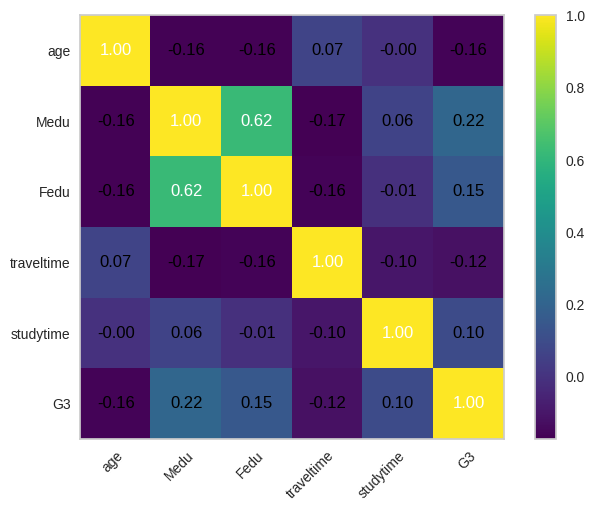

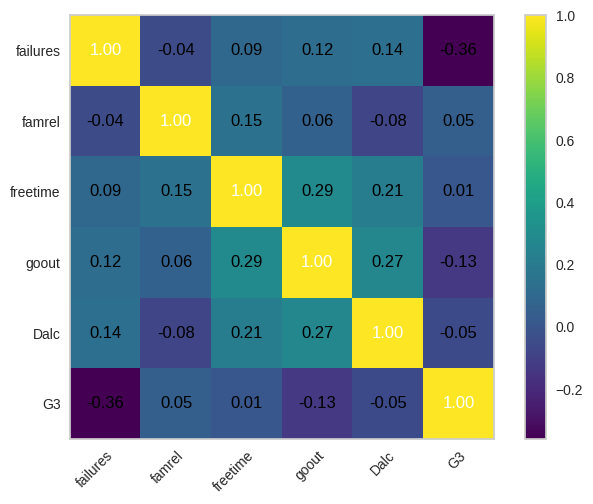

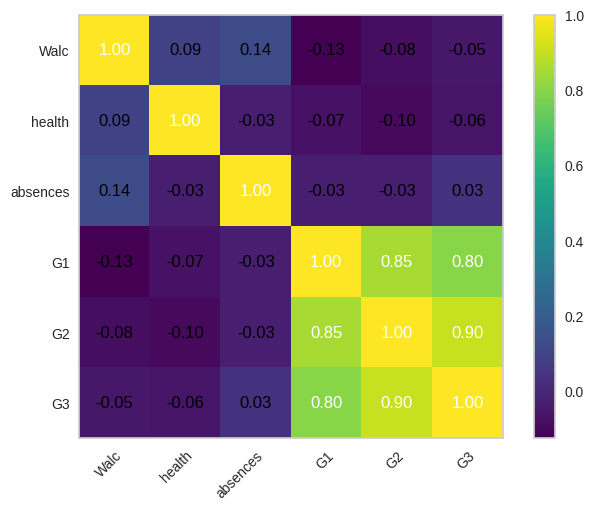

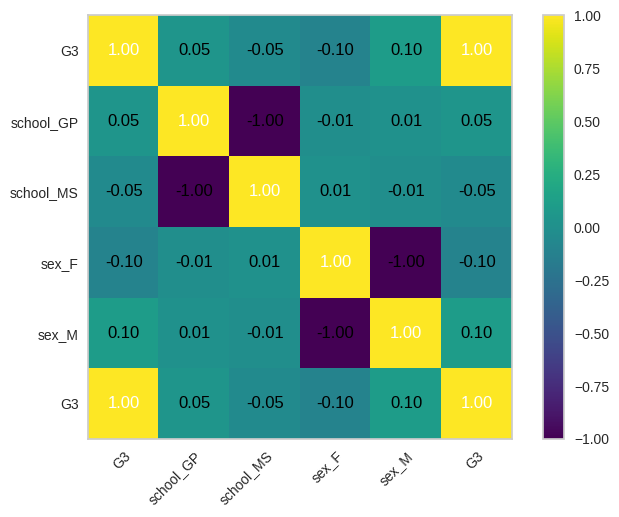

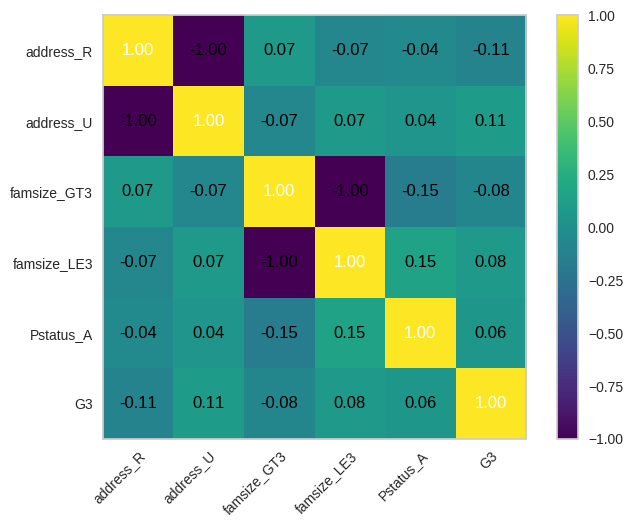

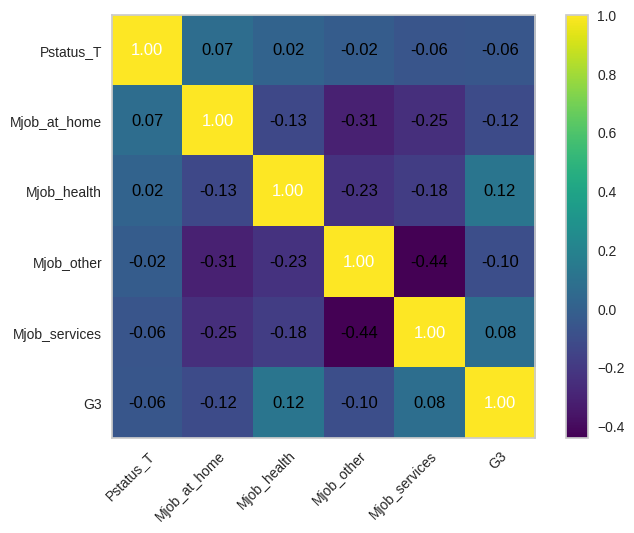

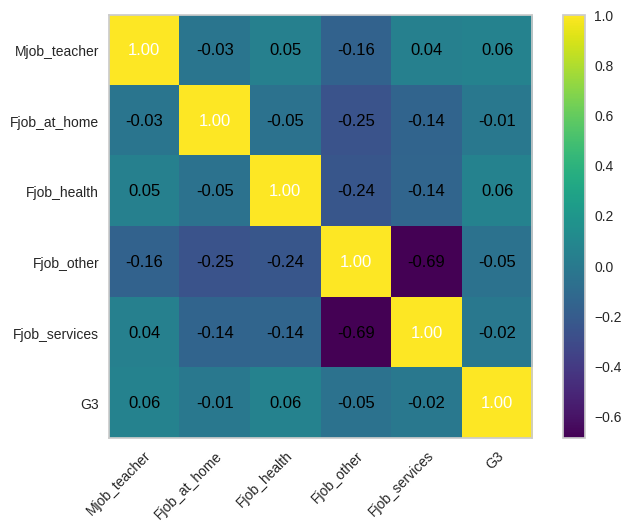

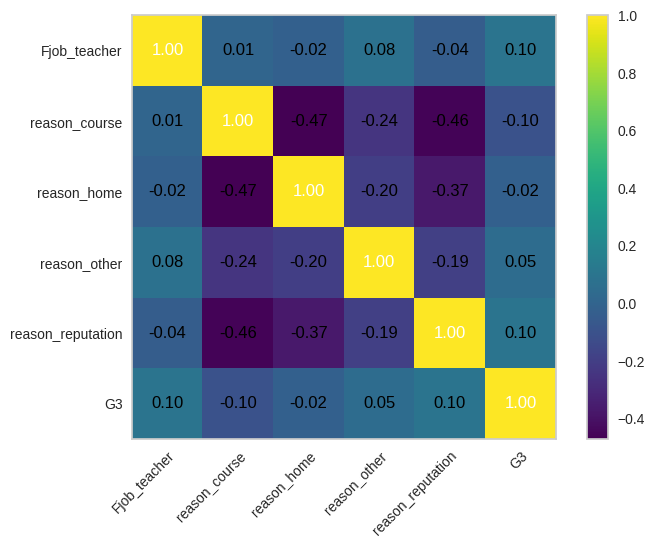

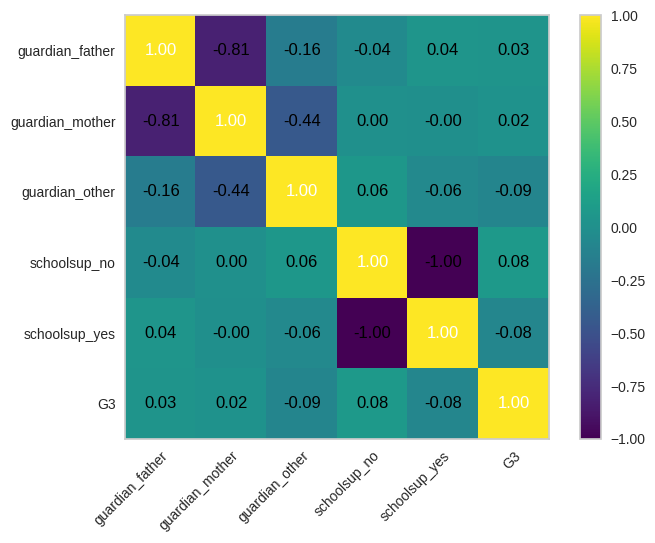

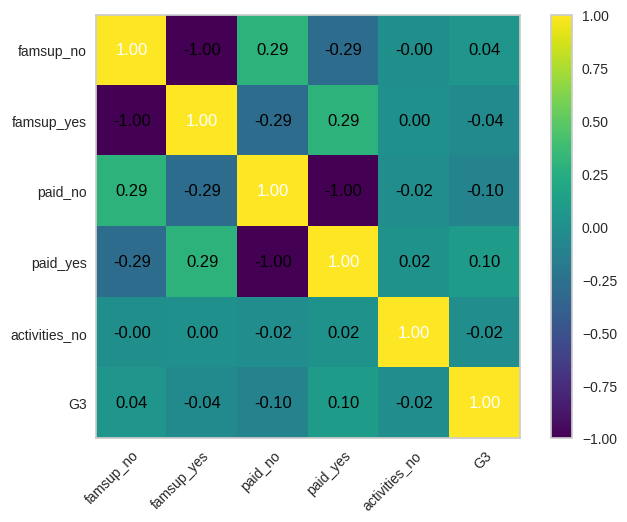

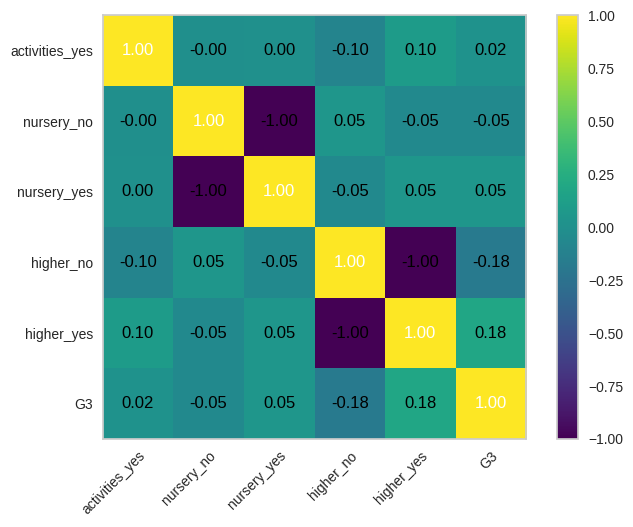

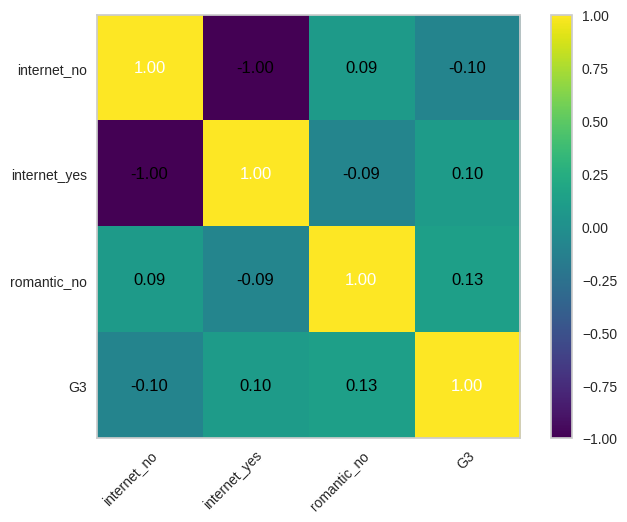

In [119]:
# Mapas de calor para identificar la correlación entre diferentes conjuntos de variables y la variable objetivo 'G3'

def plot_heatmap(a):
  cm = np.corrcoef(df_ohe[a].values.T)
  hm = heatmap(cm, row_names=a, column_names=df_ohe[a].columns)
  plt.show()

for i in range(12):
  if i == 11:
    aux = columns[5*i:-1]
  else:
    aux = columns[5*i:5*(i+1)]
  aux = np.append(aux, 'G3')
  plot_heatmap(aux)

# **División del DataFrame en conjuntos de entrenamiento y prueba**

In [120]:
X = df_ohe.loc[:,df_ohe.columns != "G3"]
y = df_ohe['G3']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [121]:
scaler = MinMaxScaler()

# **Modelo de regresión lineal múltiple**

In [122]:
# Se crea una canalización con escalado y regresión lineal múltiple
pipe_lr = make_pipeline(scaler, LinearRegression())

# Crear un objeto KFold para la validación cruzada
kf = KFold(n_splits=15, shuffle=True, random_state=42)

# Realizar la validación cruzada y obtener los puntajes (scores)
scores = cross_val_score(pipe_lr, X_train, y_train, cv=kf, scoring='r2')

# Print the R^2 scores for each fold
for i, score in enumerate(scores):
    print(f'Fold {i + 1} R^2 Score: {score:.2f}')

# You can also calculate the mean and standard deviation of the scores
mean_score = scores.mean()
std_score = scores.std()

print(f'Mean R^2 Score: {mean_score:.2f}')
print(f'Standard Deviation of R^2 Scores: {std_score:.2f}')

Fold 1 R^2 Score: 0.89
Fold 2 R^2 Score: 0.54
Fold 3 R^2 Score: 0.81
Fold 4 R^2 Score: 0.71
Fold 5 R^2 Score: 0.89
Fold 6 R^2 Score: 0.78
Fold 7 R^2 Score: 0.68
Fold 8 R^2 Score: 0.66
Fold 9 R^2 Score: 0.50
Fold 10 R^2 Score: 0.91
Fold 11 R^2 Score: 0.93
Fold 12 R^2 Score: 0.77
Fold 13 R^2 Score: 0.68
Fold 14 R^2 Score: 0.88
Fold 15 R^2 Score: -2.18
Mean R^2 Score: 0.56
Standard Deviation of R^2 Scores: 0.74


In [123]:
# Se ajusta el modelo a los datos de entrenamiento
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [150]:
y_pred_train = pipe_lr.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train):.2f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MSE: {mean_squared_error(y_train, y_pred_train)}')

R2: 0.87
MAE: 1.1646813501285602
MSE: 2.8230178991827786


In [151]:
y_pred = pipe_lr.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2: 0.72
MAE: 1.6469031225276898
MSE: 5.656886022113547


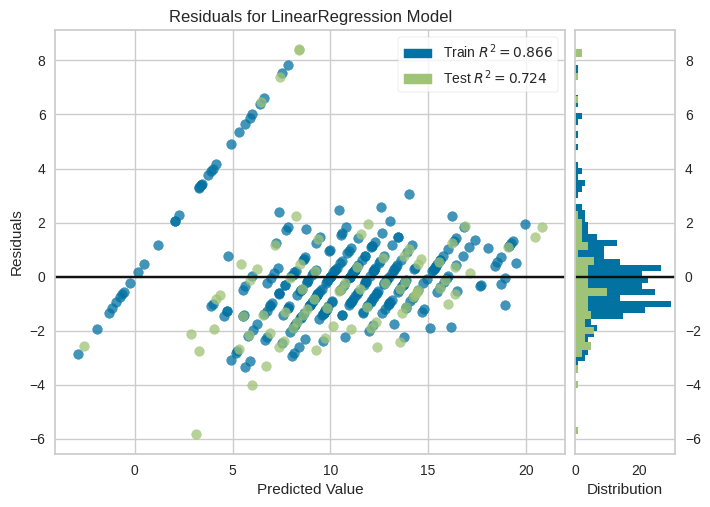

In [126]:
# Create the visualizer, fit, score, and show it
viz = residuals_plot(LinearRegression(), X_train, y_train, X_test, y_test)

In [127]:
# Se calcula el coeficiente de determinación R²
pipe_lr.score(X_test, y_test)

0.7241222637451111

# **Modelo de regresión con Random Forest Regression**

In [128]:
# Se crea una canalización con escalado y modelo de Random Forest
scaler = MinMaxScaler()
rf = RandomForestRegressor(random_state=42)
pipe_rf = Pipeline([
    ('scaler', scaler),
    ('regressor', rf)
])

cv_value = 15
trees = [3,4,5]
criteria = ["squared_error","poisson"]
max_features = ['sqrt','log2']

# Minimum number of samples required to split a node
min_samples_split = [10, 15, 17, 19]

# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 5, 7, 9]

depths = [2,3]

param_grid = {
    'regressor__n_estimators': trees,  # RandomForestRegressor parameter
    'regressor__criterion': criteria,
    'regressor__max_depth': depths,  # RandomForestRegressor parameter
    'regressor__min_samples_split': min_samples_split,
    'regressor__min_samples_leaf': min_samples_leaf
}

gs = GridSearchCV(estimator=pipe_rf,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True # set this for train score
                  )
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 15 folds for each of 192 candidates, totalling 2880 fits
0.8551471772494685
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 3, 'regressor__min_samples_leaf': 9, 'regressor__min_samples_split': 19, 'regressor__n_estimators': 5}


In [129]:
y_pred_train = gs.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train):.2f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MSE: {mean_squared_error(y_train, y_pred_train)}')


R2: 0.87
MAE: 1.026641292951591
MSE: 2.7122950426746106


In [130]:
y_pred = gs.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')


R2: 0.80
MAE: 1.3386853160310246
MSE: 4.189933480299735


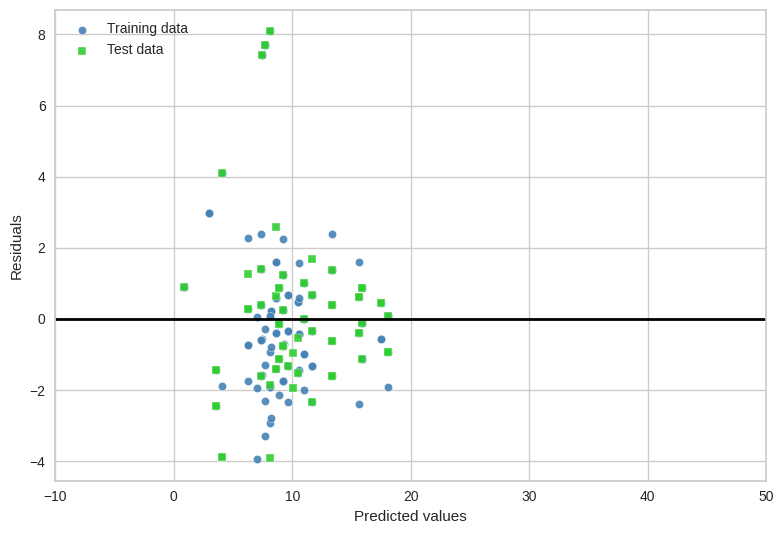

In [131]:
plt.scatter(y_pred_train,
            y_pred_train - y_train,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Training data')
plt.scatter(y_pred,
            y_pred - y_test,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35,
            alpha=0.9,
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

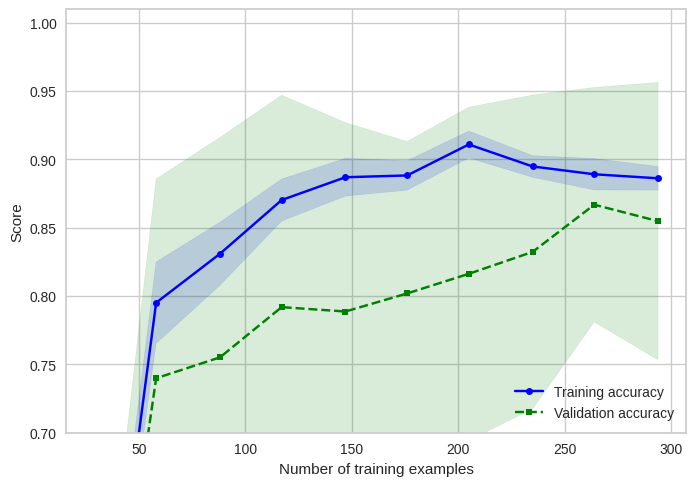

In [132]:
rf_regressor = gs.best_estimator_

train_sizes, train_scores, test_scores =\
 learning_curve(estimator=rf_regressor,
 X=X_train,
 y=y_train,
 train_sizes=np.linspace(
 0.1, 1.0, 10),
 cv=cv_value,
 n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(
    train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid(True)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim([0.7, 1.01])
plt.show()

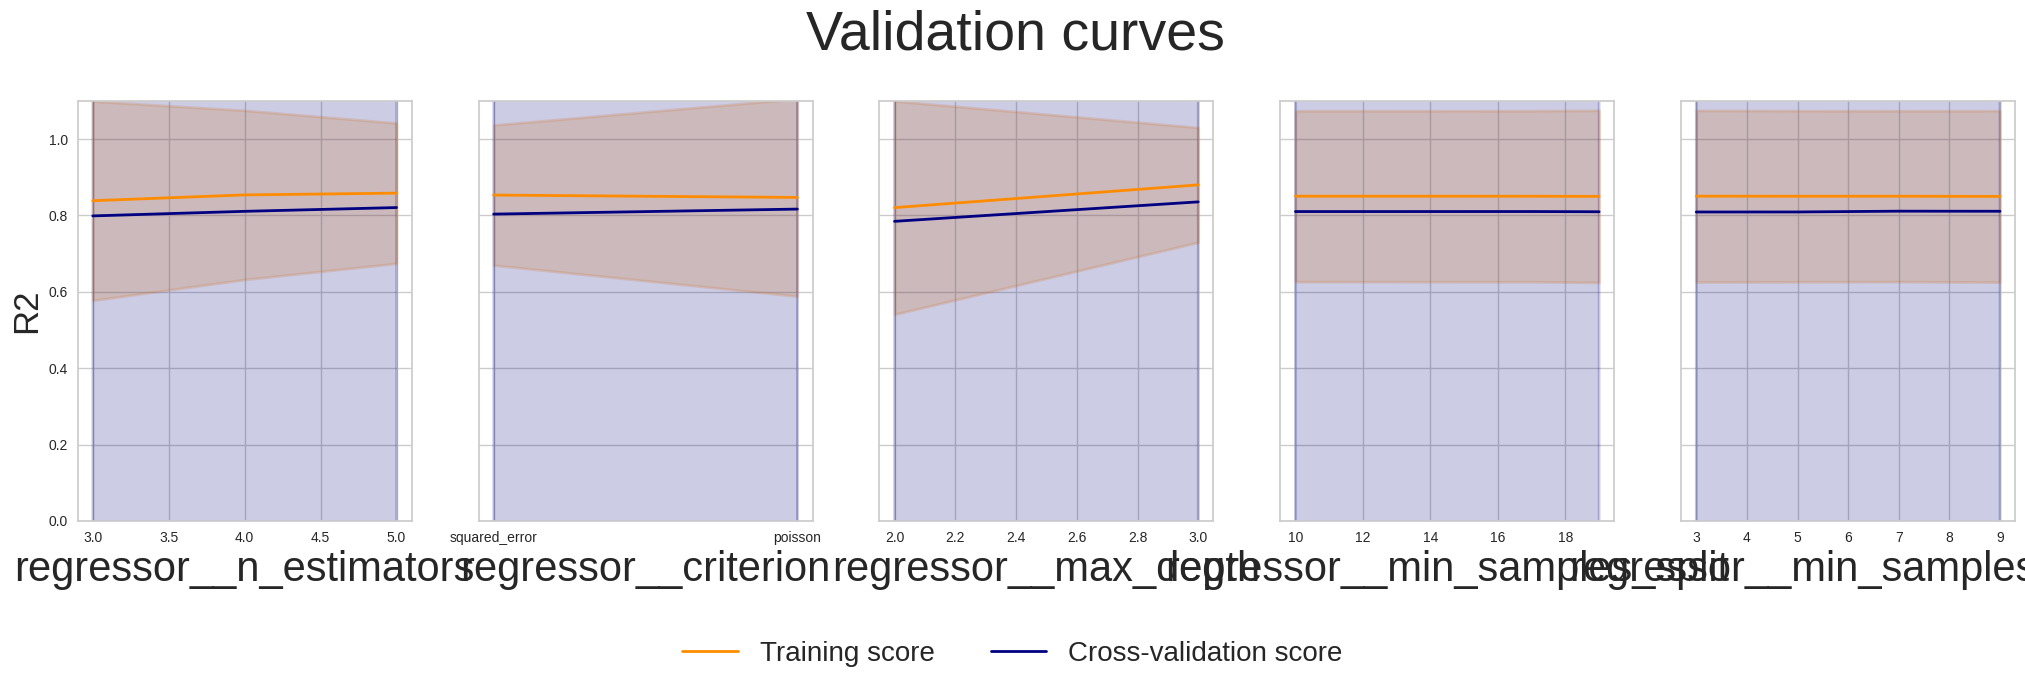

In [133]:
# fuente: https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv

df_gs = pd.DataFrame(gs.cv_results_)
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score',
           'std_train_score']

# https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
def pooled_var(stds):
    n = cv_value # size of cv in gridsearch
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))


fig, axes = plt.subplots(1, len(param_grid),
                         figsize = (5*len(param_grid), 7),
                         sharey='row')
axes[0].set_ylabel("R2", fontsize=25)
lw = 2

for idx, (param_name, param_range) in enumerate(param_grid.items()):
    grouped_df = df_gs.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = df_gs.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=30)
    axes[idx].set_ylim(0.0, 1.1)
    axes[idx].plot(param_range,
                grouped_df['mean_train_score'],
                label="Training score",
                color="darkorange",
                lw=lw)
    axes[idx].fill_between(param_range,
                grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                alpha=0.2,
                color="darkorange",
                lw=lw)
    axes[idx].plot(param_range,
                grouped_df['mean_test_score'],
                label="Cross-validation score",
                color="navy",
                lw=lw)
    axes[idx].fill_between(param_range,
                    grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                    alpha=0.2,
                    color="navy",
                    lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=40)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

fig.subplots_adjust(bottom=0.25, top=0.85)
plt.show()

# **Modelo de regresión utilizando Support Vector Regression(SVR) con un kernel RBF**

In [134]:
# Se crea una canalización con escalado y modelo de Support Vector Regression
scaler = MinMaxScaler()
svr = SVR()
pipe_svr = Pipeline([
    ('scaler', scaler),
    ('regressor', svr)
])

cv_value = 15
kernel = ["rbf"]
c = [2, 3, 5, 7]
epsilon = [0.001, 0.01]
#max_iter = [5000]

param_grid = {
    'regressor__kernel': kernel,  # SVR parameter
    'regressor__C': c,
    'regressor__epsilon': epsilon,
    #'regressor__max_iter': max_iter,  # RandomForestRegressor parameter
}

gs_svr = GridSearchCV(estimator=pipe_svr,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True # set this for train score
                  )
gs_svr = gs_svr.fit(X_train, y_train)

print(gs_svr.best_score_)
print(gs_svr.best_params_)

Fitting 15 folds for each of 8 candidates, totalling 120 fits
0.6528485993413874
{'regressor__C': 7, 'regressor__epsilon': 0.001, 'regressor__kernel': 'rbf'}


In [135]:
y_pred_train = gs_svr.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train):.2f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MSE: {mean_squared_error(y_train, y_pred_train)}')

R2: 0.88
MAE: 0.5710593369355877
MSE: 2.601783600702709


In [136]:
y_pred = gs_svr.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2: 0.69
MAE: 1.7051888919855183
MSE: 6.364950321710457


In [137]:
svr_regressor = gs_svr.best_estimator_

train_sizes, train_scores, test_scores =\
 learning_curve(estimator=svr_regressor,
 X=X_train,
 y=y_train,
 train_sizes=np.linspace(
 0.1, 1.0, 10),
 cv=cv_value,
 n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

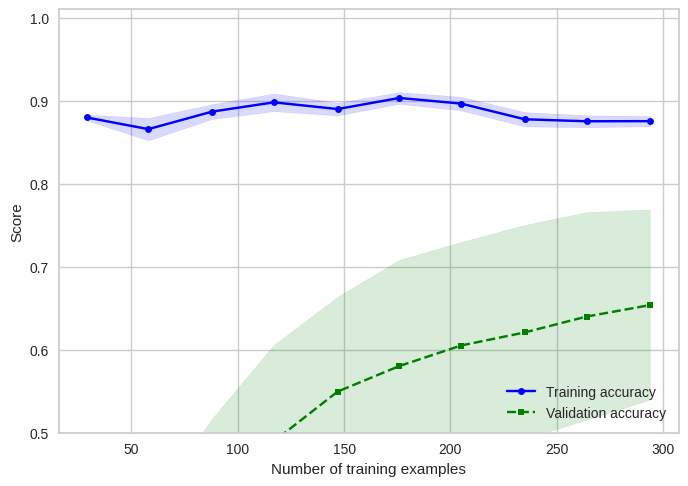

In [138]:
plt.plot(
    train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid(True)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.01])
plt.show()

# **Modelo de regresión utilizando Redes Neuronales Artificiales(ANN)**

In [139]:
ann = MLPRegressor(random_state=42)
steps = [
    ('scaler', MinMaxScaler()),
    ('regressor', ann)
]
pipe_mlp = Pipeline(steps)

hidden_layers_param = [
    (100,),
    (25, 25),
    #(100, 100),
    (100, 50, 25),
    (25,25,25,25),
]

max_iter_param = [
    1000,
    1500,
    #500
]

param_grid = {
    'regressor__hidden_layer_sizes': hidden_layers_param,
    'regressor__max_iter': max_iter_param,
}

cv_value = 15 # Valor para el # de pliegues en validación cruzada
gs_mlp = GridSearchCV(
    estimator=pipe_mlp,
    param_grid=param_grid,
    cv=cv_value,
    scoring='r2',
    refit=True,
    n_jobs=-1,
    verbose = 3,
    return_train_score=True # set this for train score
)

gs_mlp.fit(X, y)

Fitting 15 folds for each of 8 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('regressor',
                                        MLPRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__hidden_layer_sizes': [(100,), (25, 25),
                                                           (100, 50, 25),
                                                           (25, 25, 25, 25)],
                         'regressor__max_iter': [1000, 1500]},
             return_train_score=True, scoring='r2', verbose=3)

In [140]:
print(gs_mlp.best_score_)
print(gs_mlp.best_params_)

0.6811637320252903
{'regressor__hidden_layer_sizes': (100,), 'regressor__max_iter': 1000}


In [141]:
y_pred_train = gs_mlp.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train):.2f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MSE: {mean_squared_error(y_train, y_pred_train)}')

R2: 0.97
MAE: 0.4938127615052357
MSE: 0.5554394509951419


In [142]:
y_pred = gs_mlp.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2: 0.95
MAE: 0.6735304021061175
MSE: 1.032848549481201


In [143]:
def plot_learning_curve(estimator, X_train, y_train, cv = 10):
  train_sizes, train_scores, test_scores =\
  learning_curve(
      estimator=estimator,
      X=X_train,
      y=y_train,
      train_sizes=np.linspace(
      0.1, 1.0, 10),
      cv = cv,
      n_jobs=1)

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)


  plt.plot(
      train_sizes, train_mean,
      color='blue', marker='o',
      markersize=5, label='Training accuracy')

  plt.fill_between(train_sizes,
                   train_mean + train_std,
                   train_mean - train_std,
                   alpha=0.15, color='blue')
  plt.plot(train_sizes, test_mean,
           color='green', linestyle='--',
           marker='s', markersize=5,
           label='Validation accuracy')

  plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
  plt.grid(True)
  plt.xlabel('Number of training examples')
  plt.ylabel('Score')
  plt.legend(loc='lower right')
  plt.ylim([0.7, 1.01])
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

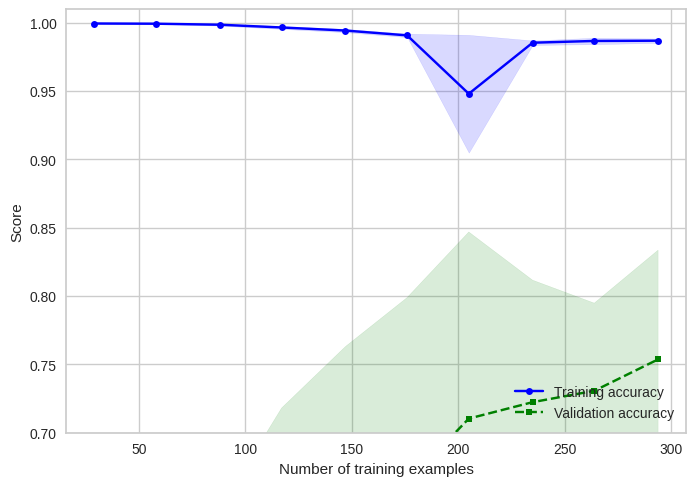

In [144]:
mlp_regressor = gs_mlp.best_estimator_
plot_learning_curve(mlp_regressor, X_train, y_train, cv = cv_value)

# **Técnica de aprendizaje automático AdaBoost Regressor**

In [146]:
# Se crea una canalización con escalado y técnica AdaBoost
scaler = MinMaxScaler()
ada = AdaBoostRegressor(random_state=42)
pipe_ada = Pipeline([
    ('scaler', scaler),
    ('regressor', ada)
])

cv_value = 15
n_estimators = [3, 4, 5, 10]
learning_rate = [0.01, 0.1, 0.5, 0.7, 1, 1.5, 2, 2.5]
loss = ["linear", "square", "exponential"]

param_grid = {

    'regressor__n_estimators': n_estimators,
    'regressor__learning_rate': learning_rate,
    'regressor__loss': loss
}

gs_ada = GridSearchCV(estimator=pipe_ada,
                  param_grid=param_grid,
                  scoring='r2',
                  cv=cv_value,
                  refit=True,
                  n_jobs=-1,
                  verbose = 3,
                  return_train_score=True # set this for train score
                  )
gs_ada = gs_ada.fit(X_train, y_train)

print(gs_ada.best_score_)
print(gs_ada.best_params_)

Fitting 15 folds for each of 96 candidates, totalling 1440 fits
0.8904151676129967
{'regressor__learning_rate': 0.7, 'regressor__loss': 'linear', 'regressor__n_estimators': 10}


In [147]:
y_pred_train = gs_ada.predict(X_train)

print(f'R2: {r2_score(y_train, y_pred_train):.2f}')
print(f'MAE: {mean_absolute_error(y_train, y_pred_train)}')
print(f'MSE: {mean_squared_error(y_train, y_pred_train)}')

R2: 0.93
MAE: 0.9108025805714092
MSE: 1.4209667652968696


In [148]:
y_pred = gs_ada.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2: 0.82
MAE: 1.165084052116188
MSE: 3.7172128936578717


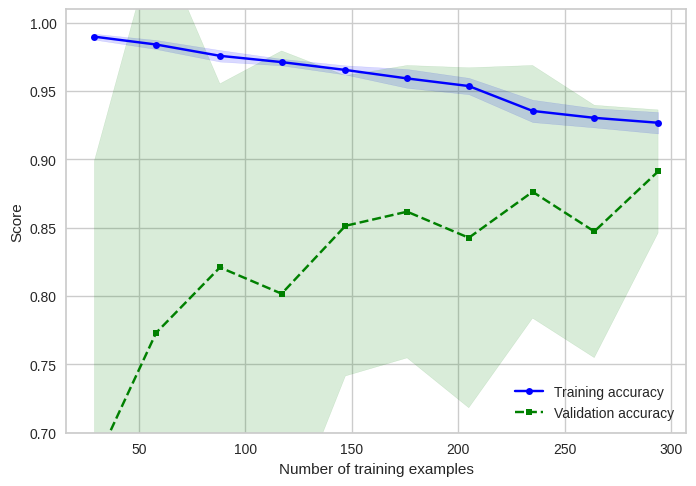

In [149]:
ada_regressor = gs_ada.best_estimator_

train_sizes, train_scores, test_scores =\
 learning_curve(estimator=ada_regressor,
 X=X_train,
 y=y_train,
 train_sizes=np.linspace(
 0.1, 1.0, 10),
 cv=cv_value,
 n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(
    train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid(True)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.ylim([0.7, 1.01])
plt.show()